# Solar Energy Forecasting - Model Training and Evaluation

This notebook trains and evaluates **five regression/time-series models** for solar power forecasting:
1. **Linear Regression** (Baseline)
2. **Random Forest Regressor**
3. **XGBoost Regressor** (GPU-accelerated)
4. **LSTM Neural Network** (GPU-accelerated)
5. **Prophet** (Facebook's Time-Series Model)

**Hardware Optimizations**: Configured for 32GB RAM and GPU acceleration

## 1. Setup and Data Loading

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from prophet import Prophet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib
import warnings
warnings.filterwarnings('ignore')

from data_preprocessing import SolarDataPreprocessor
from config import MODEL_DIR, MODEL_CONFIG

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"XGBoost version: {xgb.__version__}")

c:\Users\agrer\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.20.0
GPU Available: []
XGBoost version: 3.1.3


c:\Users\agrer\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
print("Loading and preprocessing data...\n")
preprocessor = SolarDataPreprocessor()
data = preprocessor.preprocess_pipeline(plant_id=1)

X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']
feature_names = data['feature_names']

print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")

Loading and preprocessing data...

SOLAR DATA PREPROCESSING PIPELINE
Loading data for Plant 1...
Generation data shape: (68778, 7)
Weather data shape: (3182, 6)
Aggregating generation data across inverters...
Cleaning data...
Rows after cleaning: 3158 (removed 0)
Cleaning data...
Rows after cleaning: 3182 (removed 0)
Merging generation and weather data...
Merged data shape: (3157, 10)
Engineering features...
Features after engineering: 29
Creating chronological train/validation/test split...
Train set: 2193 samples (2020-05-15 06:00:00 to 2020-06-08 04:15:00)
Validation set: 470 samples (2020-06-08 04:30:00 to 2020-06-13 01:45:00)
Test set: 470 samples (2020-06-13 02:00:00 to 2020-06-17 23:45:00)
Selected 22 numeric features for training
Selected 22 numeric features for training
Selected 22 numeric features for training
PREPROCESSING COMPLETE

Training set: (2193, 22)
Validation set: (470, 22)
Test set: (470, 22)
Number of features: 22


## 2. Data Exploration and Visualization

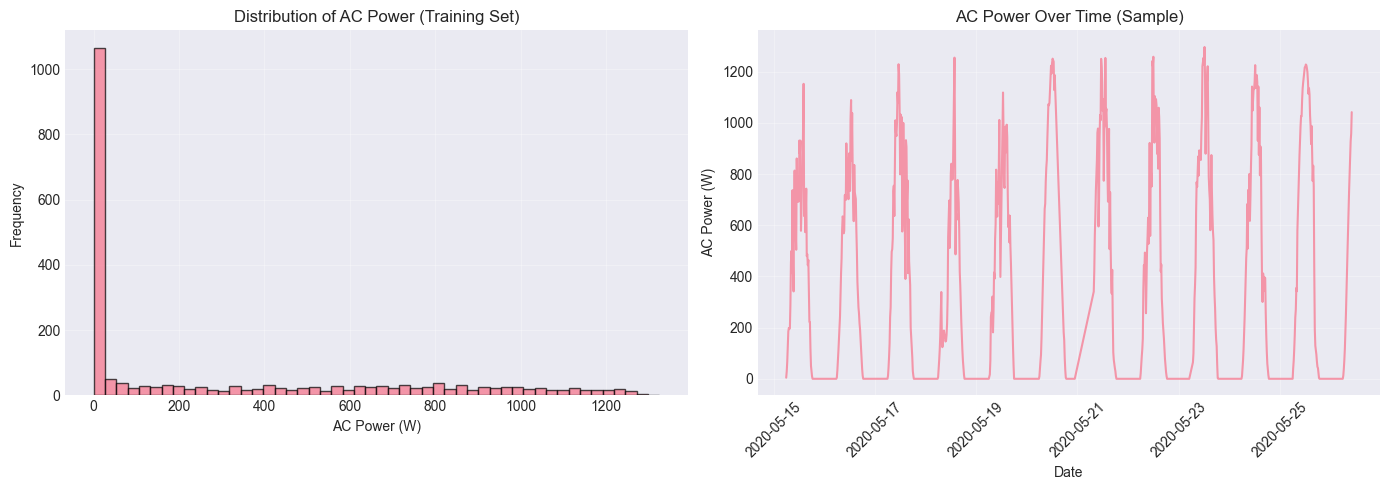

AC Power Statistics:
Mean: 313.87 W
Std: 399.58 W
Max: 1325.01 W


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('AC Power (W)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of AC Power (Training Set)')
axes[0].grid(True, alpha=0.3)

sample_size = min(1000, len(data['train_dates']))
axes[1].plot(data['train_dates'][:sample_size], y_train[:sample_size], alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('AC Power (W)')
axes[1].set_title('AC Power Over Time (Sample)')
axes[1].grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"AC Power Statistics:")
print(f"Mean: {y_train.mean():.2f} W")
print(f"Std: {y_train.std():.2f} W")
print(f"Max: {y_train.max():.2f} W")

## 3. Feature Scaling

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## 4. Model Training and Evaluation

### Helper Functions

In [5]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  MAE:  {mae:.2f} W")
    print(f"  RMSE: {rmse:.2f} W")
    print(f"  R²:   {r2:.4f}")
    
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

def plot_predictions(y_true, y_pred, model_name, sample_size=500):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].scatter(y_true[:sample_size], y_pred[:sample_size], alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Power (W)')
    axes[0].set_ylabel('Predicted Power (W)')
    axes[0].set_title(f'{model_name}: Actual vs Predicted')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(y_true[:sample_size], label='Actual', alpha=0.7)
    axes[1].plot(y_pred[:sample_size], label='Predicted', alpha=0.7)
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Power (W)')
    axes[1].set_title(f'{model_name}: Time Series Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

results = []

### Model 1: Linear Regression (Baseline)

Training Model 1: Linear Regression

Linear Regression Performance:
  MAE:  17.29 W
  RMSE: 30.44 W
  R²:   0.9934


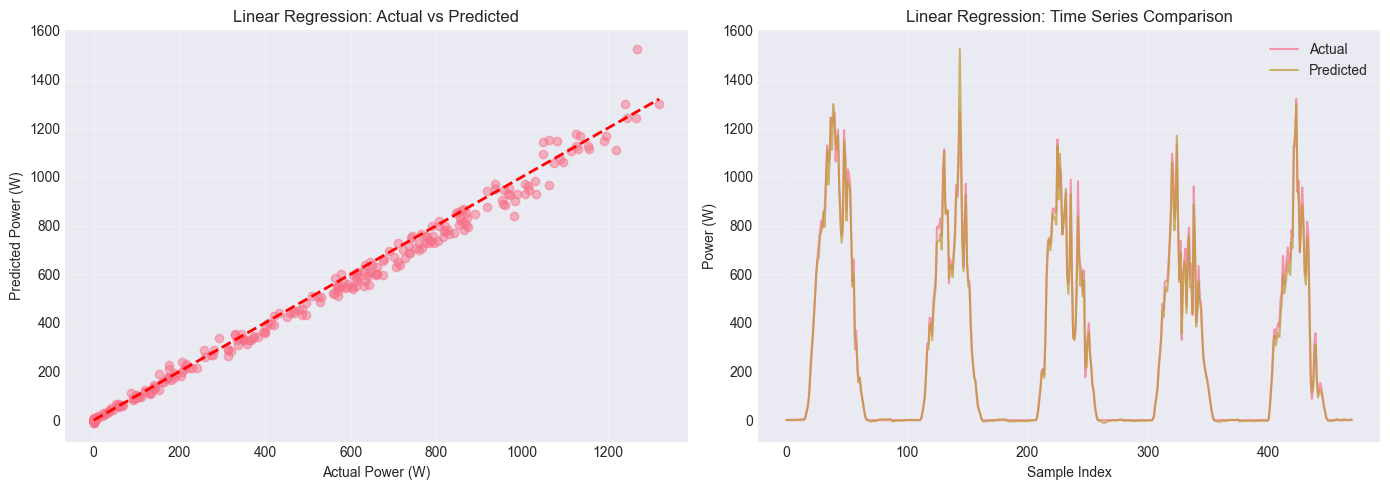

In [6]:
print("="*60)
print("Training Model 1: Linear Regression")
print("="*60)

lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

lr_results = evaluate_model(y_test, y_pred_lr, "Linear Regression")
results.append(lr_results)

plot_predictions(y_test.values, y_pred_lr, "Linear Regression")

### Model 2: Random Forest Regressor

Training Model 2: Random Forest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.0s finished



Random Forest Performance:
  MAE:  11.93 W
  RMSE: 24.94 W
  R²:   0.9956

Top 10 Important Features:
                        feature  importance
2                   IRRADIATION    0.995629
16  IRRADIATION_rolling_mean_6h    0.000454
11              AC_POWER_lag_6h    0.000375
20  IRRADIATION_rolling_std_24h    0.000359
6                   day_of_year    0.000330
1            MODULE_TEMPERATURE    0.000316
14   IRRADIATION_rolling_std_3h    0.000314
10              AC_POWER_lag_3h    0.000290
17   IRRADIATION_rolling_std_6h    0.000287
4                           day    0.000276


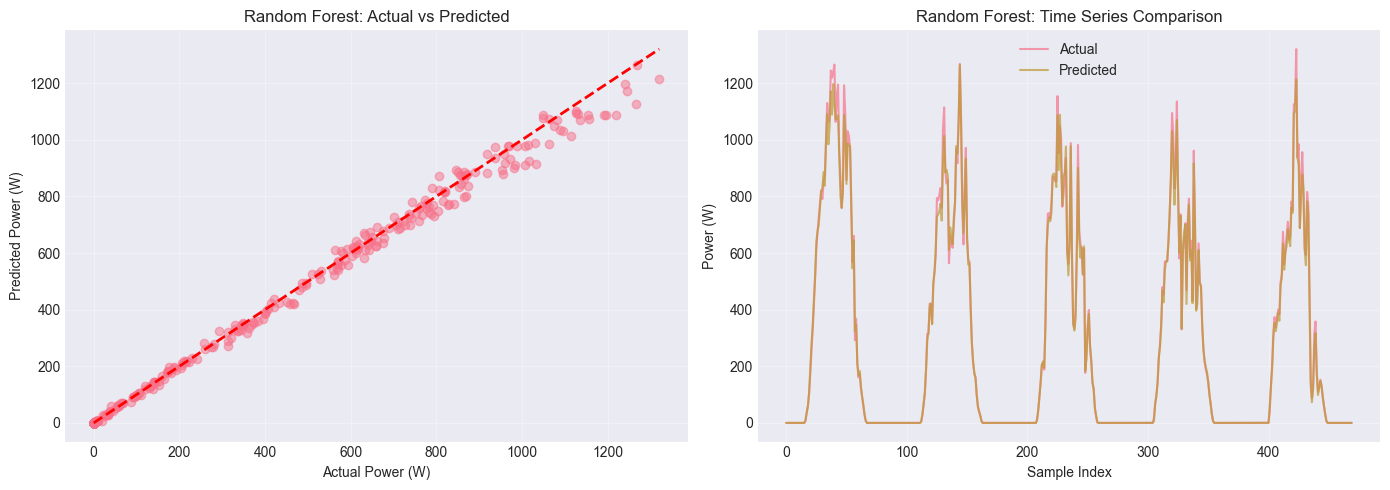

In [7]:
print("="*60)
print("Training Model 2: Random Forest")
print("="*60)

rf_config = MODEL_CONFIG['random_forest']
rf_model = RandomForestRegressor(**rf_config, verbose=1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rf_results = evaluate_model(y_test, y_pred_rf, "Random Forest")
results.append(rf_results)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

plot_predictions(y_test.values, y_pred_rf, "Random Forest")

### Model 3: XGBoost Regressor (GPU-Accelerated)

Training Model 3: XGBoost (GPU)
GPU not detected, using CPU (hist)
[0]	validation_0-rmse:352.19908
[1]	validation_0-rmse:334.84452
[2]	validation_0-rmse:318.35583
[3]	validation_0-rmse:302.72633
[4]	validation_0-rmse:287.88263
[5]	validation_0-rmse:273.98744
[6]	validation_0-rmse:260.72347
[7]	validation_0-rmse:248.07860
[8]	validation_0-rmse:235.97158
[9]	validation_0-rmse:224.46782
[10]	validation_0-rmse:213.69892
[11]	validation_0-rmse:203.30878
[12]	validation_0-rmse:193.52945
[13]	validation_0-rmse:184.32877
[14]	validation_0-rmse:175.56063
[15]	validation_0-rmse:167.18636
[16]	validation_0-rmse:159.22201
[17]	validation_0-rmse:151.70335
[18]	validation_0-rmse:144.59303
[19]	validation_0-rmse:137.89209
[20]	validation_0-rmse:131.86835
[21]	validation_0-rmse:126.02792
[22]	validation_0-rmse:120.31790
[23]	validation_0-rmse:115.09897
[24]	validation_0-rmse:109.91187
[25]	validation_0-rmse:105.51271
[26]	validation_0-rmse:101.14711
[27]	validation_0-rmse:96.68367
[28]	validation_0-rm

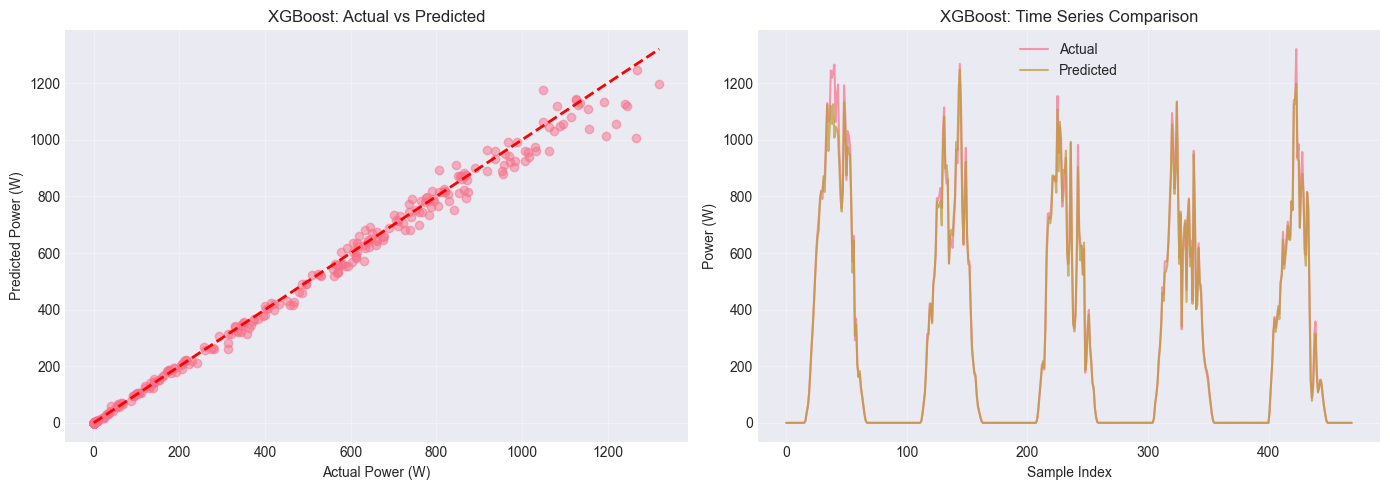

In [8]:
print("="*60)
print("Training Model 3: XGBoost (GPU)")
print("="*60)

xgb_config = MODEL_CONFIG['xgboost'].copy()

if len(tf.config.list_physical_devices('GPU')) == 0:
    print("GPU not detected, using CPU (hist)")
    xgb_config['tree_method'] = 'hist'
    xgb_config.pop('gpu_id', None)

xgb_config['early_stopping_rounds'] = 20
xgb_config['verbosity'] = 1

xgb_model = xgb.XGBRegressor(**xgb_config)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

y_pred_xgb = xgb_model.predict(X_test)

xgb_results = evaluate_model(y_test, y_pred_xgb, "XGBoost")
results.append(xgb_results)

plot_predictions(y_test.values, y_pred_xgb, "XGBoost")

### Model 4: LSTM Neural Network (GPU-Accelerated)

Training Model 4: LSTM Neural Network
Sequence shape: (2169, 24, 22)

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,945 (511.50 KB)

 Trainable params: 130,945 (511.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 256826.1562 - mae: 311.7951 - val_loss: 213171.2812 - val_mae: 283.9983
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 251837.0781 - mae: 309.9575 - val_loss: 207700.7188 - val_mae: 282.7148
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 245663.6094 - mae: 308.8038 - val_loss: 201919.0781 - val_mae: 279.7087
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 238811.6250 - mae: 305.4228 - val_loss: 194958.4375 - val_mae: 271.2265
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 231006.8438 - mae: 297.4450 - val_loss: 187196.3438 - val_mae: 268.4042
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 221650.1719 - mae: 290.2269 - val_loss: 178347.3750 - val_mae: 255.5900
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 211432.2812 - mae: 278.8525 - val_loss: 168311.0312 - val_mae: 246.0794
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 200187.3438 - ma

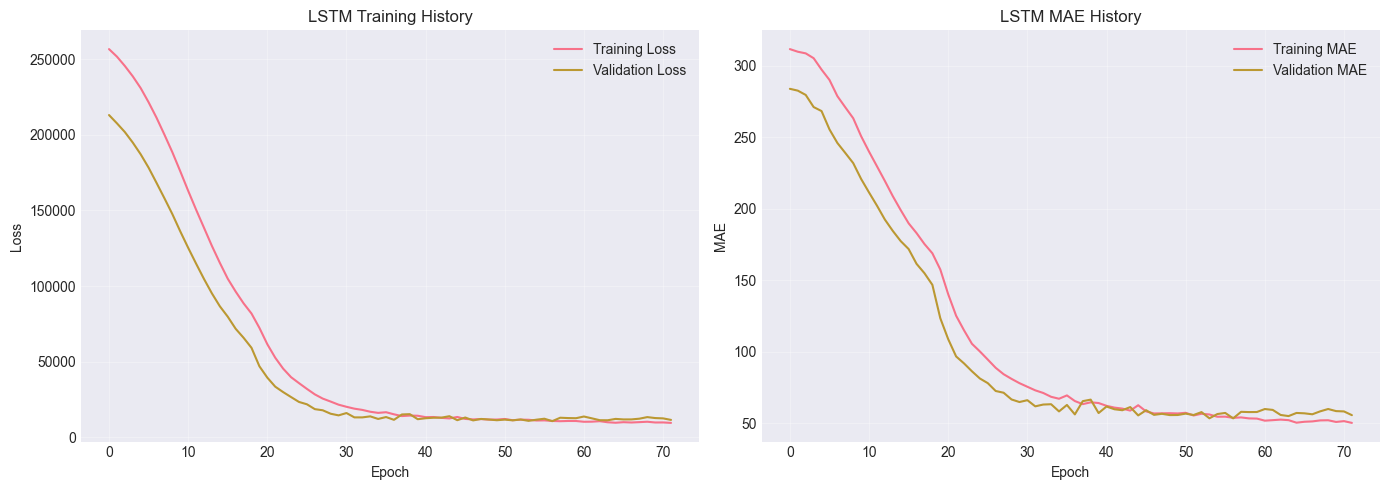

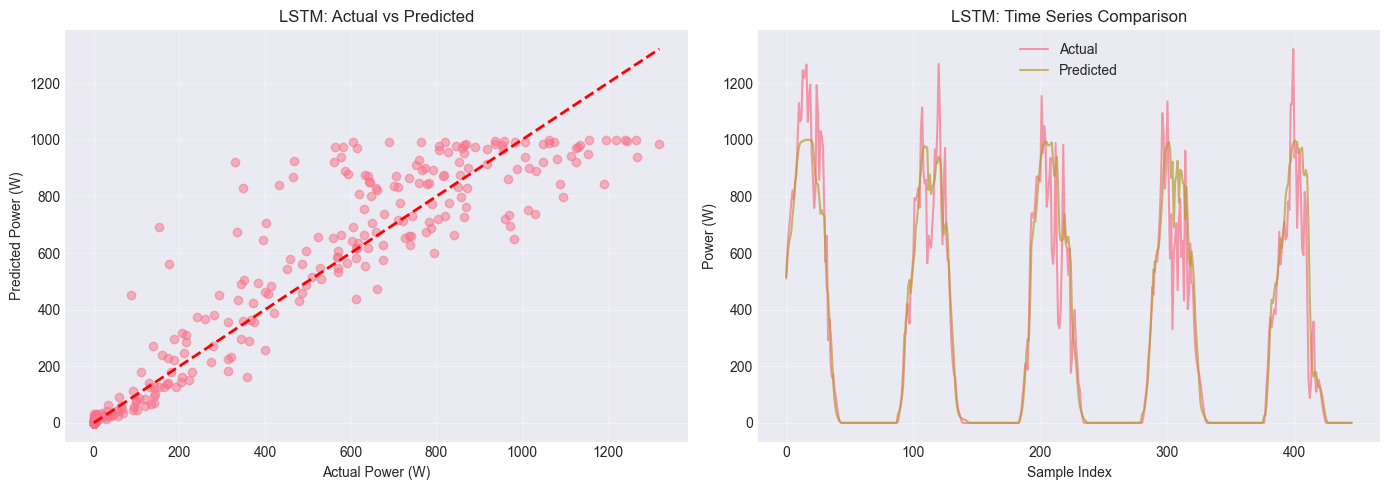

In [9]:
print("="*60)
print("Training Model 4: LSTM Neural Network")
print("="*60)

def create_sequences(X, y, seq_length):
    """Create sequences for LSTM"""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

lstm_config = MODEL_CONFIG['lstm']
seq_length = lstm_config['sequence_length']

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, seq_length)

print(f"Sequence shape: {X_train_seq.shape}")

lstm_model = keras.Sequential([
    layers.LSTM(lstm_config['lstm_units'][0], return_sequences=True, 
                input_shape=(seq_length, X_train.shape[1])),
    layers.Dropout(lstm_config['dropout']),
    layers.LSTM(lstm_config['lstm_units'][1]),
    layers.Dropout(lstm_config['dropout']),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nLSTM Model Architecture:")
lstm_model.summary()

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=lstm_config['early_stopping_patience'],
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=lstm_config['epochs'],
    batch_size=lstm_config['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

y_pred_lstm = lstm_model.predict(X_test_seq, verbose=0).flatten()

lstm_results = evaluate_model(y_test_seq, y_pred_lstm, "LSTM")
results.append(lstm_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LSTM Training History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('LSTM MAE History')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plot_predictions(y_test_seq, y_pred_lstm, "LSTM")

### Model 5: Prophet (Time-Series Model)

03:15:46 - cmdstanpy - INFO - Chain [1] start processing


Training Model 5: Prophet


03:15:47 - cmdstanpy - INFO - Chain [1] done processing



Prophet Performance:
  MAE:  135.30 W
  RMSE: 140.60 W
  R²:   0.8590


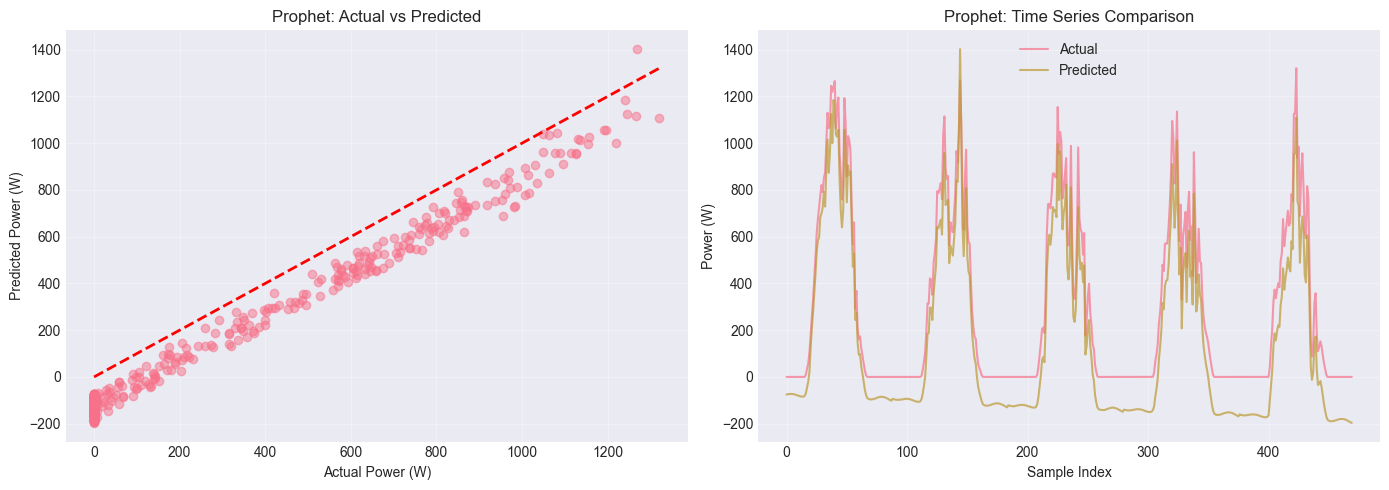

In [10]:
print("="*60)
print("Training Model 5: Prophet")
print("="*60)

prophet_train = pd.DataFrame({
    'ds': data['train_dates'],
    'y': y_train.values
})

prophet_test = pd.DataFrame({
    'ds': data['test_dates']
})

prophet_config = MODEL_CONFIG['prophet']
prophet_model = Prophet(**prophet_config, interval_width=0.95)

prophet_train['irradiation'] = X_train['IRRADIATION'].values
prophet_train['temperature'] = X_train['AMBIENT_TEMPERATURE'].values
prophet_train['hour'] = X_train['hour'].values

prophet_test['irradiation'] = X_test['IRRADIATION'].values
prophet_test['temperature'] = X_test['AMBIENT_TEMPERATURE'].values
prophet_test['hour'] = X_test['hour'].values

prophet_model.add_regressor('irradiation')
prophet_model.add_regressor('temperature')
prophet_model.add_regressor('hour')

prophet_model.fit(prophet_train)

forecast = prophet_model.predict(prophet_test)
y_pred_prophet = forecast['yhat'].values

prophet_results = evaluate_model(y_test, y_pred_prophet, "Prophet")
results.append(prophet_results)

plot_predictions(y_test.values, y_pred_prophet, "Prophet")

## 5. Model Comparison and Selection

In [11]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

best_model_name = results_df.iloc[0]['model']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   RMSE: {best_rmse:.2f} W")
print(f"   R²: {results_df.iloc[0]['R2']:.4f}")


MODEL COMPARISON
            model        MAE       RMSE       R2
    Random Forest  11.925194  24.938534 0.995563
          XGBoost  12.697612  28.928080 0.994030
Linear Regression  17.288297  30.444687 0.993388
             LSTM  61.975892 117.471744 0.904099
          Prophet 135.303342 140.599729 0.858977

🏆 BEST MODEL: Random Forest
   RMSE: 24.94 W
   R²: 0.9956


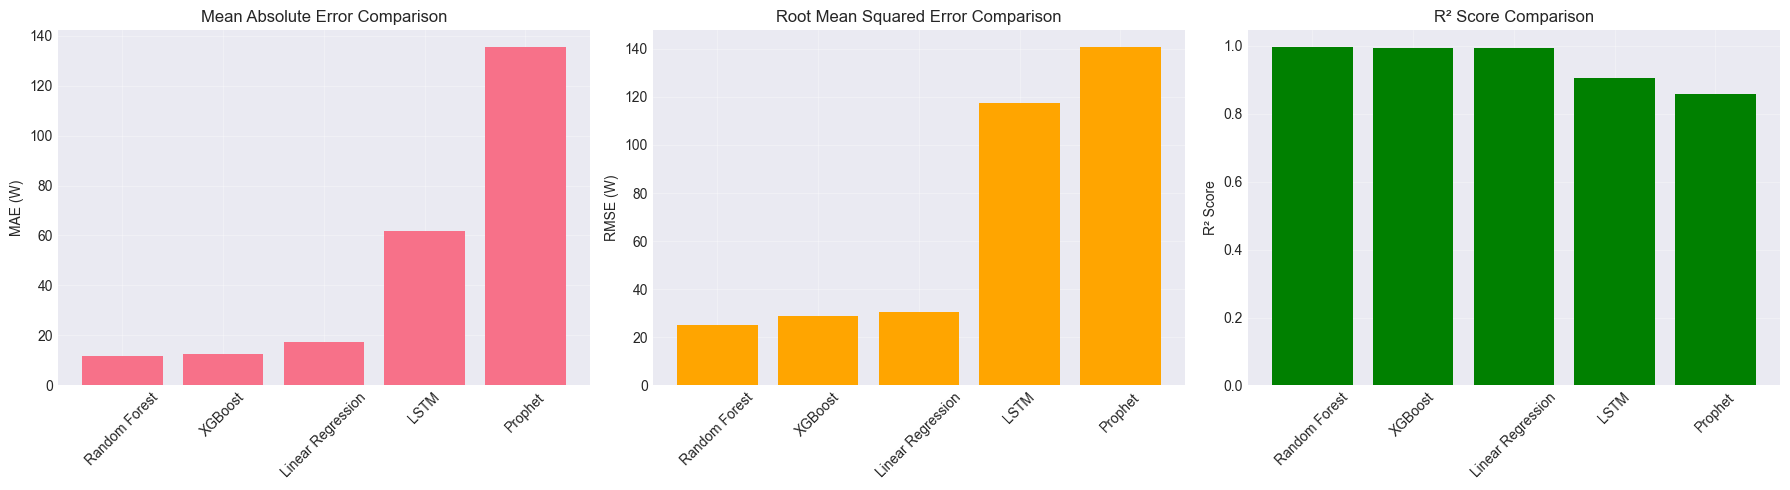

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(results_df['model'], results_df['MAE'])
axes[0].set_ylabel('MAE (W)')
axes[0].set_title('Mean Absolute Error Comparison')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].bar(results_df['model'], results_df['RMSE'], color='orange')
axes[1].set_ylabel('RMSE (W)')
axes[1].set_title('Root Mean Squared Error Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

axes[2].bar(results_df['model'], results_df['R2'], color='green')
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Score Comparison')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Save Best Model

In [13]:
model_map = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LSTM': lstm_model,
    'Prophet': prophet_model
}

best_model = model_map[best_model_name]

model_data = {
    'model': best_model,
    'model_name': best_model_name,
    'scaler': scaler,
    'feature_names': feature_names,
    'metrics': results_df.iloc[0].to_dict(),
    'training_date': pd.Timestamp.now().isoformat()
}

model_path = MODEL_DIR / 'best_model.pkl'
joblib.dump(model_data, model_path)

print(f"\n✅ Best model saved to: {model_path}")
print(f"   Model type: {best_model_name}")
print(f"   RMSE: {best_rmse:.2f} W")
print(f"   Features: {len(feature_names)}")


✅ Best model saved to: d:\Solar Panel\notebooks\..\models\best_model.pkl
   Model type: Random Forest
   RMSE: 24.94 W
   Features: 22


## 7. Summary and Conclusions

In [14]:
print("\n" + "="*60)
print("TRAINING COMPLETE - SUMMARY")
print("="*60)
print(f"\nDataset: Plant 1 Solar Generation Data")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(feature_names)}")
print(f"\nModels trained: 5")
print(f"Best model: {best_model_name}")
print(f"Best RMSE: {best_rmse:.2f} W")
print(f"Best R²: {results_df.iloc[0]['R2']:.4f}")
print(f"\nModel saved: {model_path}")
print("\nNext steps:")
print("  1. Run Streamlit app: streamlit run app.py")
print("  2. Generate 48-hour forecasts")
print("  3. Get optimization recommendations")
print("="*60)


TRAINING COMPLETE - SUMMARY

Dataset: Plant 1 Solar Generation Data
Training samples: 2193
Test samples: 470
Features: 22

Models trained: 5
Best model: Random Forest
Best RMSE: 24.94 W
Best R²: 0.9956

Model saved: d:\Solar Panel\notebooks\..\models\best_model.pkl

Next steps:
  1. Run Streamlit app: streamlit run app.py
  2. Generate 48-hour forecasts
  3. Get optimization recommendations
